# Glue Job for Data Analysis 


####  Initiating required python packages for Glue Job


In [1]:
%idle_timeout 2880
%glue_version 4.0
%worker_type G.1X
%number_of_workers 5


import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job
import boto3
import ast
from pyspark.sql.functions import explode
import matplotlib.pyplot as plt
import numpy as np
  
sc = SparkContext.getOrCreate()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.5 
Current idle_timeout is None minutes.
idle_timeout has been set to 2880 minutes.
Setting Glue version to: 4.0
Previous worker type: None
Setting new worker type to: G.1X
Previous number of workers: None
Setting new number of workers to: 5
Trying to create a Glue session for the kernel.
Session Type: glueetl
Worker Type: G.1X
Number of Workers: 5
Idle Timeout: 2880
Session ID: 5bbb739f-875e-4440-b18b-3a57dfb9198d
Applying the following default arguments:
--glue_kernel_version 1.0.5
--enable-glue-datacatalog true
Waiting for session 5bbb739f-875e-4440-b18b-3a57dfb9198d to get into ready status...
Session 5bbb739f-875e-4440-b18b-3a57dfb9198d ha

In [3]:
# Function for creatign dataframe from s3 location
def sourceJsonDFFromS3(source):
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket='maithrinet', Key='input/'+source+'.json')
    object_content = response["Body"].read().decode("utf-8").strip()
    object_content = ast.literal_eval(object_content)
    object_content = spark.createDataFrame(object_content[source])
    return  object_content 

In [10]:
# Creation of Orders dataframe from S3 and displaying 10 records of orders df
orders = sourceJsonDFFromS3('orders')
orders.createOrReplaceTempView('orders')
orders = spark.sql("Select order_id,customer_id ,order_date, items.quantity, items.item_id , items.product_name , items.price,total_amount \
from \
(select order_id,customer_id ,order_date,explode(items) as items,total_amount from orders)")
orders.createOrReplaceTempView('ordersDF')
orders.show(10,False)

+--------+-----------+----------+--------+-------+-------------------+------+------------+
|order_id|customer_id|order_date|quantity|item_id|product_name       |price |total_amount|
+--------+-----------+----------+--------+-------+-------------------+------+------------+
|5001    |1001       |2024-01-15|1       |A123   |Laptop             |1200.0|1250.0      |
|5001    |1001       |2024-01-15|2       |B456   |Mouse              |25.0  |1250.0      |
|5002    |1002       |2024-01-16|1       |C789   |Keyboard           |75.0  |75.0        |
|5003    |1003       |2024-01-17|2       |D012   |Monitor            |200.0 |400.0       |
|5004    |1004       |2024-01-18|1       |E345   |Printer            |150.0 |150.0       |
|5005    |1005       |2024-01-19|1       |F678   |Tablet             |300.0 |300.0       |
|5006    |1006       |2024-01-20|1       |G901   |Headphones         |100.0 |100.0       |
|5007    |1007       |2024-01-21|1       |H234   |Webcam             |50.0  |50.0        |

In [11]:
# Creation of Products dataframe from S3 and displaying 10 records of products df
products = sourceJsonDFFromS3('products')
products.createOrReplaceTempView('productsDF')
products.show(10, False)

+-----------+------+----------+-------------------+--------------+
|category   |price |product_id|product_name       |stock_quantity|
+-----------+------+----------+-------------------+--------------+
|Electronics|1200.0|P001      |Laptop             |50            |
|Electronics|25.0  |P002      |Mouse              |200           |
|Electronics|75.0  |P003      |Keyboard           |150           |
|Electronics|200.0 |P004      |Monitor            |70            |
|Electronics|150.0 |P005      |Printer            |30            |
|Electronics|300.0 |P006      |Tablet             |60            |
|Electronics|100.0 |P007      |Headphones         |100           |
|Electronics|50.0  |P008      |Webcam             |80            |
|Electronics|700.0 |P009      |Smartphone         |40            |
|Electronics|150.0 |P010      |External Hard Drive|90            |
+-----------+------+----------+-------------------+--------------+
only showing top 10 rows


In [13]:
# Creation of Users dataframe from S3 and displaying 10 records of users df
users = sourceJsonDFFromS3('users')
users.createOrReplaceTempView('users')
users = spark.sql("Select user_id,name.first_name ,name.last_name,contact.email,contact.phone,users.address.home.street  home_street ,users.address.home.city home_city,users.address.home.zipcode home_zipcode ,\
users.address.office.street  office_street ,users.address.office.city office_city,users.address.office.zipcode office_zipcode from users")
users.createOrReplaceTempView('usersDF')
users.show(10, False)

+-------+----------+---------+------------------------+-----------+----------------+-------------+------------+----------------+-----------+--------------+
|user_id|first_name|last_name|email                   |phone      |home_street     |home_city    |home_zipcode|office_street   |office_city|office_zipcode|
+-------+----------+---------+------------------------+-----------+----------------+-------------+------------+----------------+-----------+--------------+
|1001   |John      |Doe      |john.doe@email.com      |+1123456789|123 Main St     |Seattle      |98101       |456 Office Blvd |Bellevue   |98004         |
|1002   |Jane      |Smith    |jane.smith@email.com    |+1098765432|789 Broadway Ave|New York     |10001       |123 Corporate Dr|Manhattan  |10005         |
|1003   |Alice     |Johnson  |alice.johnson@email.com |+1223344556|101 First St    |Boston       |02108       |200 Second St   |Cambridge  |02139         |
|1004   |Bob       |Williams |bob.williams@email.com  |+13334445

+-----------------+-------------+
|NumberofEmployees|office_city  |
+-----------------+-------------+
|3                |Bellevue     |
|1                |Miami Beach  |
|1                |Fort Worth   |
|3                |Cambridge    |
|3                |Vancouver    |
|1                |Oakland      |
|1                |Aurora       |
|1                |Naperville   |
|1                |Round Rock   |
|1                |Cherry Hill  |
|1                |Tacoma       |
|2                |Beaverton    |
|1                |Manhattan    |
|1                |Brentwood    |
|1                |Evanston     |
|1                |Camden       |
|1                |Burbank      |
|1                |Long Beach   |
|1                |San Marcos   |
|1                |New Braunfels|
|1                |Redmond      |
|2                |Gresham      |
+-----------------+-------------+




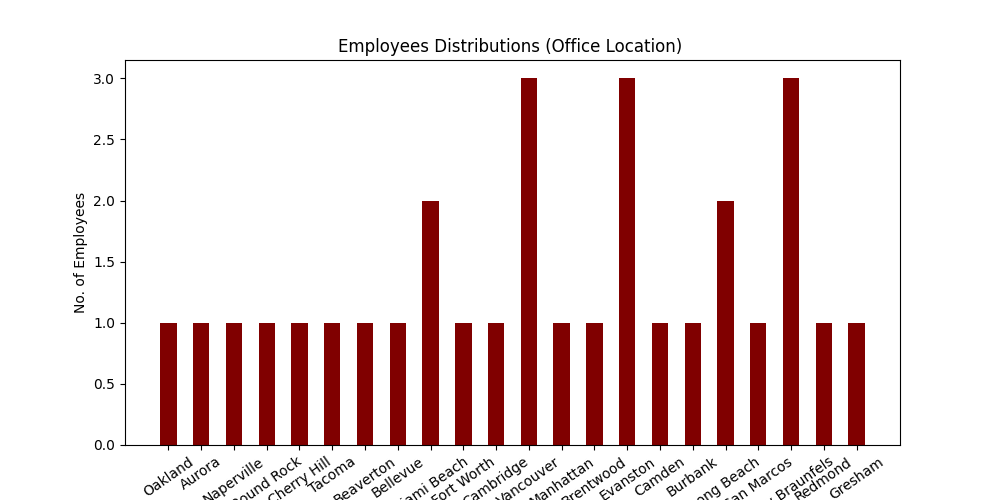

In [30]:
# Ploting the Bar graph for Employee distribution on the basis of Office Loaction
plt.clf()
numberEmployee = spark.sql("select count(1) NumberofEmployees,office_city from usersDF u  group by office_city")
numberEmployee.show(100,False)
x = numberEmployee.select('office_city').rdd.flatMap(lambda x: x).collect()
y= numberEmployee.select('NumberofEmployees').rdd.flatMap(lambda x: x).collect()

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(x, y, color ='maroon', 
        width = 0.5)

plt.xlabel(" City ")
plt.ylabel("No. of Employees")
plt.title("Employees Distributions (Office Location) ")
plt.xticks(rotation=35)
plt.show()
%matplot plt

+-----------+------+----------+-------------------+--------------+
|category   |price |product_id|product_name       |stock_quantity|
+-----------+------+----------+-------------------+--------------+
|Electronics|1200.0|P001      |Laptop             |50            |
|Electronics|25.0  |P002      |Mouse              |200           |
|Electronics|75.0  |P003      |Keyboard           |150           |
|Electronics|200.0 |P004      |Monitor            |70            |
|Electronics|150.0 |P005      |Printer            |30            |
|Electronics|300.0 |P006      |Tablet             |60            |
|Electronics|100.0 |P007      |Headphones         |100           |
|Electronics|50.0  |P008      |Webcam             |80            |
|Electronics|700.0 |P009      |Smartphone         |40            |
|Electronics|150.0 |P010      |External Hard Drive|90            |
|Electronics|30.0  |P011      |USB Flash Drive    |300           |
|Electronics|200.0 |P012      |Smartwatch         |50         

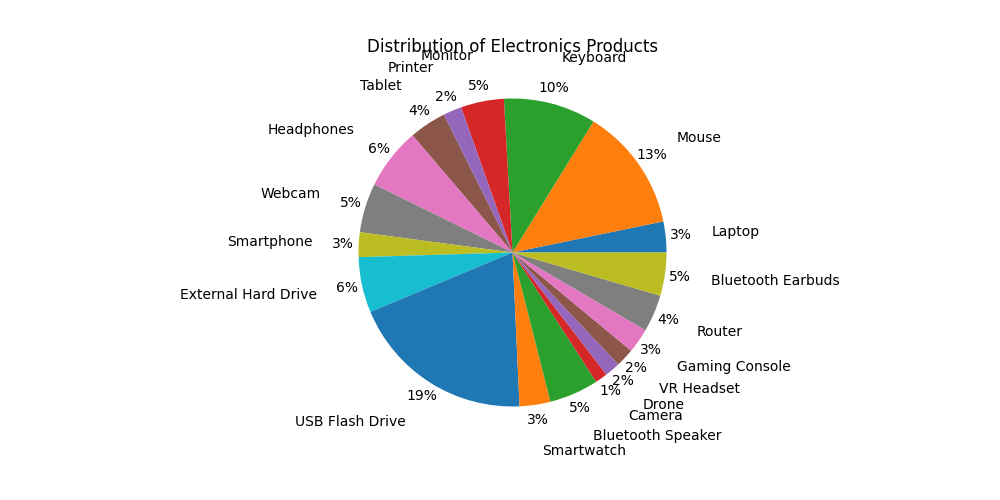

In [32]:
# Ploting the Pie graph for products quantity distribution in Electronics category
plt.clf()
category = 'Electronics'
productsPie = spark.sql("select * from productsDF p where category = '"+category+"'")
productsPie.show(100,False)
stock_quantity = productsPie.where("category = '"+category+"'").select('stock_quantity').rdd.flatMap(lambda x: x).collect()
product_name = productsPie.where("category = '"+category+"'").select('product_name').rdd.flatMap(lambda x: x).collect()
y = np.array(stock_quantity)
mylabels = product_name
plt.title('Distribution of '+category+' Products')
plt.pie(y, labels = mylabels ,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3)
plt.show() 
%matplot plt

+-----------+-----+----------+------------------+--------------+
|category   |price|product_id|product_name      |stock_quantity|
+-----------+-----+----------+------------------+--------------+
|Accessories|25.0 |P020      |Smartwatch Charger|150           |
|Accessories|350.0|P021      |Camera Lens       |30            |
|Accessories|40.0 |P022      |Tablet Stand      |80            |
+-----------+-----+----------+------------------+--------------+




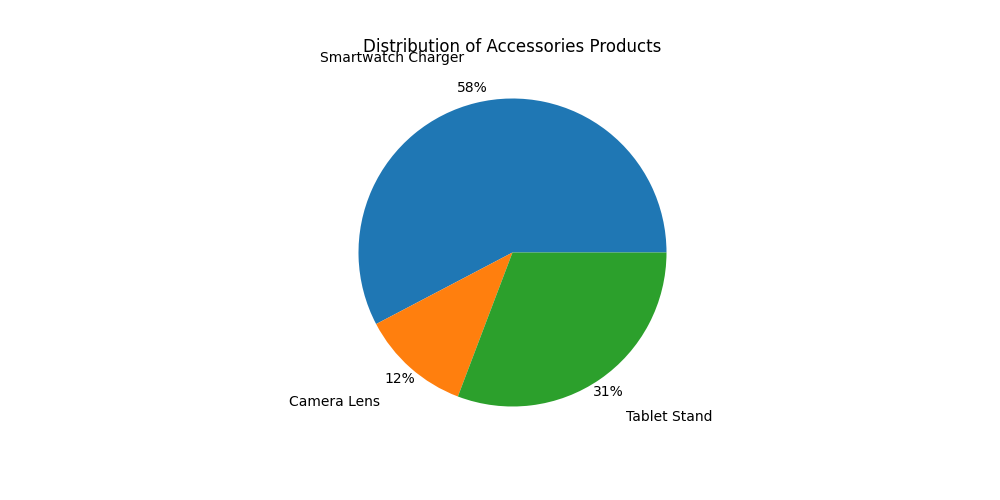

In [34]:
# Ploting the Pie graph for products quantity distribution in Accessories category
plt.clf()
category = 'Accessories'
productsPie = spark.sql("select * from productsDF p where category = '"+category+"'")
productsPie.show(100, False)
stock_quantity = productsPie.where("category = '"+category+"'").select('stock_quantity').rdd.flatMap(lambda x: x).collect()
product_name = productsPie.where("category = '"+category+"'").select('product_name').rdd.flatMap(lambda x: x).collect()
y = np.array(stock_quantity)
mylabels = product_name
plt.title('Distribution of '+category+' Products')
plt.pie(y, labels = mylabels ,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3)
plt.show() 
%matplot plt

+---------+-----+----------+--------------+--------------+
|category |price|product_id|product_name  |stock_quantity|
+---------+-----+----------+--------------+--------------+
|Furniture|60.0 |P023      |Desk Lamp     |50            |
|Furniture|150.0|P024      |Office Chair  |20            |
|Furniture|25.0 |P025      |Desk Organizer|100           |
|Furniture|45.0 |P026      |Laptop Stand  |70            |
|Furniture|35.0 |P027      |Monitor Stand |90            |
+---------+-----+----------+--------------+--------------+




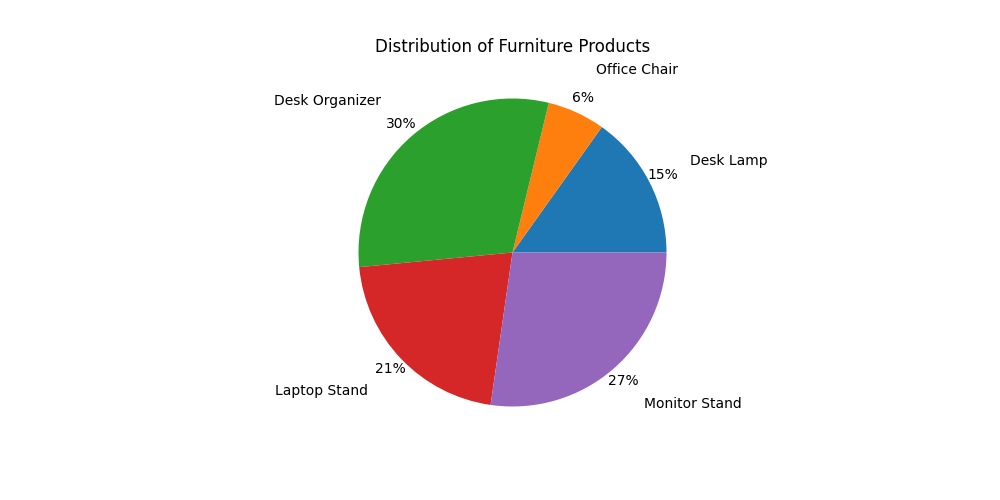

In [35]:
# Ploting the Pie graph for products quantity Furniture in Electronics category
plt.clf()
category = 'Furniture'
productsPie = spark.sql("select * from productsDF p where category = '"+category+"'")
productsPie.show(100, False)
stock_quantity = productsPie.where("category = '"+category+"'").select('stock_quantity').rdd.flatMap(lambda x: x).collect()
product_name = productsPie.where("category = '"+category+"'").select('product_name').rdd.flatMap(lambda x: x).collect()
y = np.array(stock_quantity)
mylabels = product_name
plt.title('Distribution of '+category+' Products')
plt.pie(y, labels = mylabels ,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3)
plt.show() 
%matplot plt

+---------------+-----+----------+-----------------+--------------+
|category       |price|product_id|product_name     |stock_quantity|
+---------------+-----+----------+-----------------+--------------+
|Office Supplies|10.0 |P028      |Printer Paper    |150           |
|Office Supplies|45.0 |P029      |Ink Cartridges   |100           |
|Office Supplies|15.0 |P030      |Whiteboard Marker|200           |
+---------------+-----+----------+-----------------+--------------+




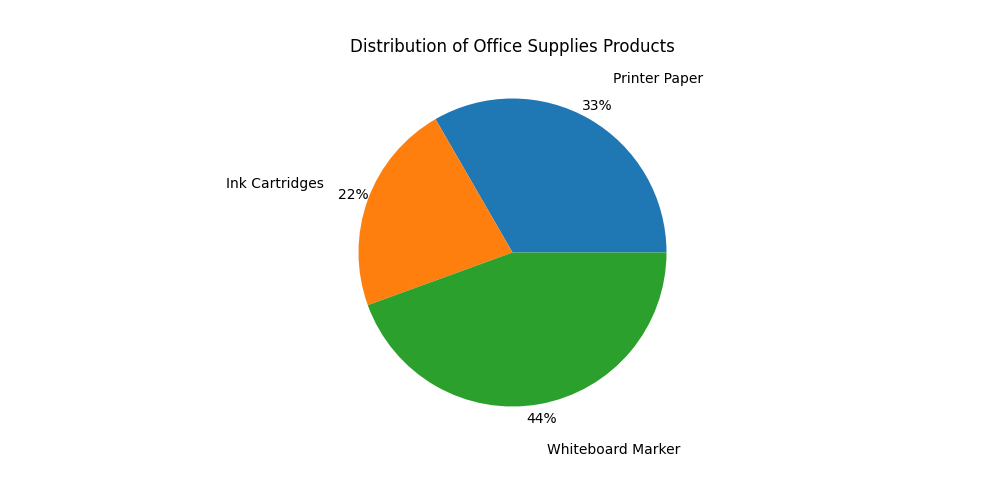

In [36]:
# Ploting the Pie graph for products quantity distribution in office Supplies category
plt.clf()
category = 'Office Supplies'
productsPie = spark.sql("select * from productsDF p where category = '"+category+"'")
productsPie.show(100, False)
stock_quantity = productsPie.where("category = '"+category+"'").select('stock_quantity').rdd.flatMap(lambda x: x).collect()
product_name = productsPie.where("category = '"+category+"'").select('product_name').rdd.flatMap(lambda x: x).collect()
y = np.array(stock_quantity)
mylabels = product_name
plt.title('Distribution of '+category+' Products')
plt.pie(y, labels = mylabels ,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3)
plt.show() 
%matplot plt

In [37]:
# Merging the orders,products and users table to form a merged data and stored in S3 loaction in json format
# Some columns of user(email and mobile columns) is PII so masked it and stored in S3(s3://maithrinet/merged_data/)

final_merged_jsonS3 = spark.sql("select u.first_name,u.last_name,base64(aes_encrypt(u.email, '1234567890abcdef', 'ECB', 'PKCS')) email\
,base64(aes_encrypt(u.phone, '1234567890abcdef', 'ECB', 'PKCS')) phone,\
u.home_street,u.home_city,u.home_zipcode,u.office_street,u.office_city\
,u.office_zipcode,temp.* from (select o.order_id,o.customer_id,o.order_date,o.item_id,o.product_name,o.quantity,o.price,\
 case when (p.category is null) then \
'Others' else \
p.category end category, \
o.price*o.quantity as finalPrice from ordersDF o left join \
productsDF p on o.product_name =p.product_name ) temp left join usersDF u on temp.customer_id = u.user_id ")
final_merged_jsonS3.repartition(1).write.mode("overwrite").format('json').save('s3://maithrinet/merged_data/')

In [38]:
# Creating a merged dataframe for analysis
final_merged_Analysis = spark.sql("select u.first_name,u.last_name,u.email,u.phone,\
u.home_street,u.home_city,u.home_zipcode,u.office_street,u.office_city\
,u.office_zipcode,temp.*,cast(date_format( temp.order_date,'yyyyMM') as int) order_month \
from (select o.order_id,o.customer_id,o.order_date,o.item_id,o.product_name,o.quantity,o.price,case when (p.category is null) then \
'Others' else \
p.category end category, \
o.price*o.quantity as finalPrice from ordersDF o left join \
productsDF p on o.product_name =p.product_name ) temp left join usersDF u on temp.customer_id = u.user_id ")
final_merged_Analysis.createOrReplaceTempView('final_merged_Analysis')
final_merged_Analysis.show(10,False)

+----------+---------+------------------------+-----------+---------------+---------+------------+----------------+-----------+--------------+--------+-----------+----------+-------+-------------------+--------+------+-----------+----------+-----------+
|first_name|last_name|email                   |phone      |home_street    |home_city|home_zipcode|office_street   |office_city|office_zipcode|order_id|customer_id|order_date|item_id|product_name       |quantity|price |category   |finalPrice|order_month|
+----------+---------+------------------------+-----------+---------------+---------+------------+----------------+-----------+--------------+--------+-----------+----------+-------+-------------------+--------+------+-----------+----------+-----------+
|Alice     |Johnson  |alice.johnson@email.com |+1223344556|101 First St   |Boston   |02108       |200 Second St   |Cambridge  |02139         |5003    |1003       |2024-01-17|D012   |Monitor            |2       |200.0 |Electronics|400.0   

+--------+-----------+
|Customer|category   |
+--------+-----------+
|2       |Others     |
|20      |Electronics|
|5       |Furniture  |
|3       |Accessories|
+--------+-----------+




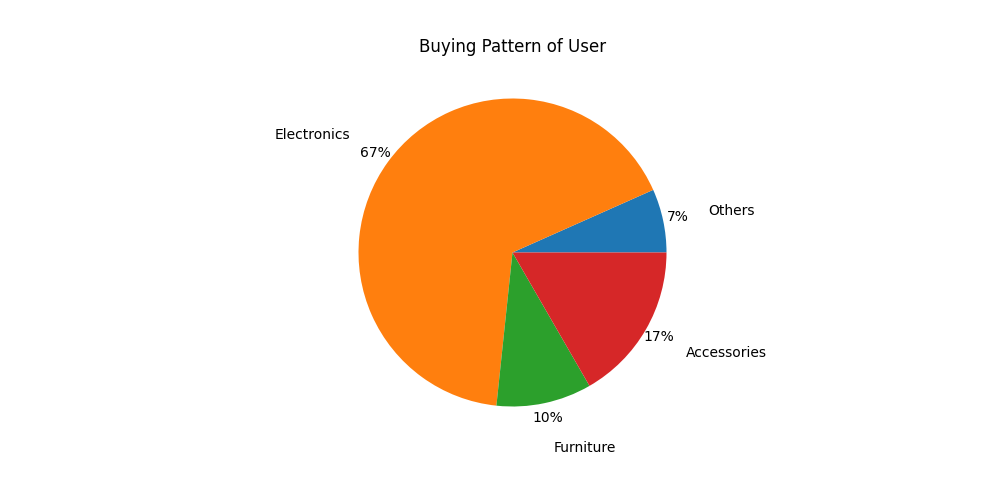

In [39]:
# Ploting the Pie graph for Buying pattern of users
categoryDistribution = spark.sql("select count(distinct customer_id) Customer,category from final_merged_Analysis group by category")
categoryDistribution.show(100, False)
plt.clf()
customer_count = categoryDistribution.select('Customer').rdd.flatMap(lambda x: x).collect()
category = categoryDistribution.select('category').rdd.flatMap(lambda x: x).collect()
y = np.array(customer_count)
mylabels = category
plt.title('Buying Pattern of User')
plt.pie(y, labels = mylabels ,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3)
plt.show() 
%matplot plt

+-----------+-----------+-----------+---------+------+
|order_month|Accessories|Electronics|Furniture|Others|
+-----------+-----------+-----------+---------+------+
|202401     |null       |5415.0     |null     |null  |
|202402     |415.0      |330.0      |375.0    |130.0 |
+-----------+-----------+-----------+---------+------+




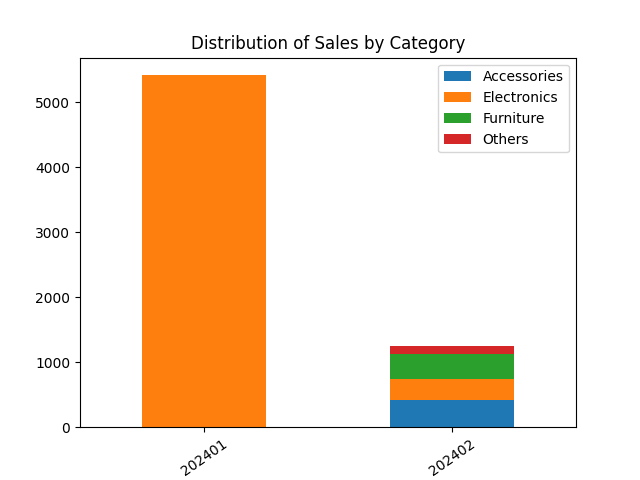

In [40]:
# Ploting the Bar graph for Sales distribution in various categories
plt.clf()
salesCat = spark.sql("select order_month,sum(finalPrice) total_price,category \
from final_merged_Analysis group by order_month,category order by order_month asc")
salesCat = salesCat.groupBy("order_month").pivot("category").sum("total_price")
salesCat.show(10,False)
salesCat = salesCat.toPandas()

# plot data in stack manner of bar type
salesCat.plot(x='order_month', kind='bar', stacked=True,
        title='Distribution of Sales by Category')
plt.xticks(rotation=35)
plt.show()
%matplot plt

+-----------------+-----------------+
|Name             |expenditure_price|
+-----------------+-----------------+
|Alice Johnson    |400.0            |
|Lucas Gonzalez   |500.0            |
|Benjamin Allen   |35.0             |
|John Doe         |1250.0           |
|Charlotte White  |120.0            |
|Levi Hall        |45.0             |
|Grace Martinez   |40.0             |
|Mason Hernandez  |400.0            |
|Liam Thomas      |200.0            |
|Michael Robinson |130.0            |
|Sofia Walker     |25.0             |
|Isabella Martinez|600.0            |
|Mia Lopez        |250.0            |
|Ella Harris      |25.0             |
|David Miller     |50.0             |
|Emily Brown      |300.0            |
|Avery Clark      |150.0            |
|Jane Smith       |75.0             |
|Chris Davis      |100.0            |
|Ethan Lee        |140.0            |
|Harper King      |60.0             |
|Henry Wright     |50.0             |
|Amelia Nguyen    |80.0             |
|Sophia Tayl

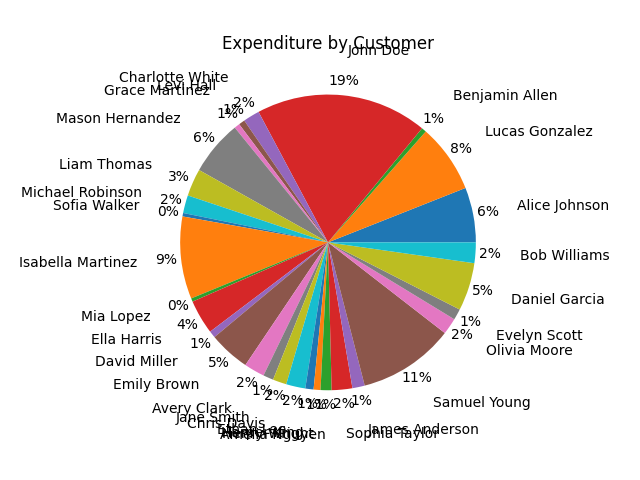

In [41]:
# Ploting the Bar graph for Expenditure by Customer
plt.clf()
customer_exp = spark.sql("Select first_name ||' '||last_name as Name ,expenditure_price from \
(select first_name,last_name,sum(finalPrice) as expenditure_price from final_merged_Analysis group by first_name,last_name) temp ")
customer_exp.show(100,False)
plt.clf()
customer = customer_exp.select('Name').rdd.flatMap(lambda x: x).collect()
exp = customer_exp.select('expenditure_price').rdd.flatMap(lambda x: x).collect()
y = np.array(exp)
mylabels = customer
plt.title('Expenditure by Customer')
plt.pie(y, labels = mylabels ,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3)
plt.show() 
%matplot plt